In [157]:
ls

LSTM_stock01.ipynb*
README.md*
ScrapYahooKeyStat.ipynb*
Stock_Prediction_General_Method.py*
Stock_Prediction_Global_Parameters.py*
Stock_Prediction_Stateless_LSTM_Model.py*
Stock_Prediction_Stateless_LSTM_Model_01.py*
Stock_Prediction_Stateless_LSTM_Model_02.py*
Stock_Prediction_Stateless_LSTM_Run.ipynb*
Stock_Prediction_Stateless_LSTM_Run.py*
Untitled.ipynb
__pycache__/
history/
multiple_input_features-Copy1.ipynb
stock_model.ipynb*
stock_prediction .ipynb
time-series_README.pdf
working_on.ipynb*


In [158]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import matplotlib.pyplot as plt
#from pandas import read_csv
import pandas as pd 
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import quandl 
%matplotlib inline 

In [159]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [160]:
ticker = 'AAPL'
stkname = "WIKI/" + str(ticker)
        # df = quandl.get(stkname, authtoken='2c24stWyXfdzLVFWxGe4', start_date=self.paras.start_date,
        #                 end_date=self.paras.end_date)
        # df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
        # df = df.rename(columns={"Adj. Open": "open", "Adj. High": "high", "Adj. Low": "low",
        #                         "Adj. Close": "close", "Adj. Volume": "volume"})

        ### add more data from here 

        # get data for stock price 
df01 = quandl.get(stkname, authtoken='2c24stWyXfdzLVFWxGe4', start_date= '1980-01-01',
                            end_date='2017-10-09')
df01 = df01[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df01 = df01.rename(columns={"Adj. Open": "open", "Adj. High": "high", "Adj. Low": "low",
                                "Adj. Close": "close", "Adj. Volume": "volume"})
df01['date'] = df01.index
        
ref_tks = ['AMZN', 'GOOGL']

d = []
for i in ref_tks:
    stkname = "WIKI/" + str(i)
    t = quandl.get(stkname, authtoken='2c24stWyXfdzLVFWxGe4', start_date= '1980-01-01',
                                    end_date='2017-10-09')

    t = t[[ 'Adj. Close']]
    t = t.rename(columns={"Adj. Close": str(i) + '_'+ "close"})
    t['date'] = t.index
    d.append(t)
df_ref = pd.concat(d, axis = 1)
        # get data for VIX 

        # df_vix_1 = quandl.get("CHRIS/CBOE_VX1", authtoken="-Cd2GkPqwZYD7_NNFF4K")
        # df_vix_1['date'] = df_vix_1.index


df = pd.concat([df01, df_ref], axis = 1, join = 'inner')
df = df[['open', 'high', 'low', 'close', 'volume', 'AMZN_close', 'GOOGL_close']]

In [161]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'AMZN_close', 'GOOGL_close'], dtype='object')

In [162]:
df_all = df.copy()

In [163]:
# all parameters 

pred_len = 10 
valid_len = 500


In [239]:
# define function to divide X into price and volume 
def divide_into_price_volume(df):

    #volume_cols = [col for col in df.columns if 'v' in col]
    return np.array(df.drop(df['volume'], 1)), np.array(df['volume'])


# preprocess data by row 

def preprocessing_data_by_row(data):
        '''
        data: N*M np.array
        N: sample
        M: features
        data_T: M*N
        data_T_scale: scaler for column by column, M*N
        data_T_scale_T: N*M
        '''
        if data.size == 0:
            return data, None

        data_T = data.transpose()
        
        scaler = preprocessing.MinMaxScaler().fit(data_T)
        
        data_T_scale = scaler.transform(data_T)
        data_T_scale_T = data_T_scale.transpose()
        return data_T_scale_T, scaler

In [240]:
df.dropna(inplace=True)

In [241]:
df['label'] = df['close'].shift(-1 * pred_len)

In [242]:
y = df['label']
X = df.drop('label', 1)

In [249]:
X.head()

,open,high,low,close,volume,AMZN_close,GOOGL_close
Date,,,,,,,
2004-08-19,2.024737,2.047227,1.950842,1.973332,97230000.0,38.63,50.322842
2004-08-20,1.973332,1.991323,1.959195,1.979115,79195200.0,39.51,54.322689
2004-08-23,1.982970,2.009315,1.966263,1.997107,63665000.0,39.45,54.869377
2004-08-24,2.008673,2.053010,2.004175,2.053010,93534000.0,39.05,52.597363
2004-08-25,2.050440,2.130119,2.038874,2.123693,126404600.0,40.30,53.164113


In [262]:
X_price, X_volume = X.drop('volume', 1), X['volume']
X_price, scaler_price = preprocessing_data_by_row(X_price)
X_volume, scaler_volume = preprocessing_data_by_row(X_volume)
#X_combined = 

ValueError: Expected 2D array, got 1D array instead:
array=[ 97230000.  79195200.  63665000. ...,  19198189.  19029621.  25015218.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [244]:
def train_test_split(x):
    return x[:int(0.7*len(x))], x[int(0.7*len(x))+1: ]

In [245]:
X_train, X_test = train_test_split(X)
y_train, y_test = train_test_split(y)

In [246]:
# X_train_price, X_train_volume = divide_into_price_volume(X_train)
# X_test_price, X_test_volume = divide_into_price_volume(X_test)

ValueError: labels [ 97230000.  79195200.  63665000. ...,  79239300.  59305400.  57010100.] not contained in axis

In [247]:
X_price, scaler_price = preprocessing_data_by_row(X_price)
X_volume, scaler_volume = preprocessing_data_by_row(X_volume)

ValueError: Expected 2D array, got 1D array instead:
array=[ 97230000.  79195200.  63665000. ...,  64717100.  78073100.  72729300.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [237]:
# X_train_price, X_train_volume = divide_into_price_volume(X_train)
# X_test_price, X_test_volume = divide_into_price_volume(X_test)

In [238]:
X_volume

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [111]:
X_price, scaler_price = preprocessing_data_by_row(X_price)
X_volume, scaler_volume = preprocessing_data_by_row(X_volume)

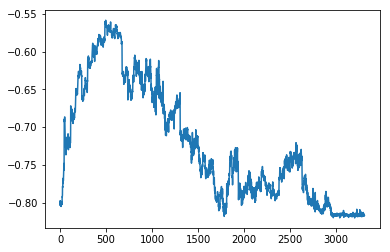

In [124]:
plt.plot(X_price[:, 0])

In [78]:
window_len = 10 
features = 'ohlcvag'
featureset = []
featuresDict = {'c': 'close', 'h': 'high', 'l': 'low', 'o': 'open', 'v': 'volume', 'a': 'AMZN_close', 'g':'GOOGL_close'}

for i in range(window_len, -1, -1):
    for j in list(features):
        df[j + '_-' + str(i) + '_d'] = df[featuresDict[j]].shift(1 * i)
        featureset.append(j + '_-' + str(i) + '_d')

In [79]:
df = df[featureset]
df.dropna(inplace=True)

In [80]:


df_lately = df[-pred_len:]
valid = df[len(df) - valid_len: len(df)]
train = df[0:len(df) - valid_len]

In [85]:
# train_y = train['close']
# #train_X = train.drop(train['close'], 1)
# train_y

train.head()

,o_-10_d,h_-10_d,l_-10_d,c_-10_d,v_-10_d,a_-10_d,g_-10_d,o_-9_d,h_-9_d,l_-9_d,...,v_-1_d,a_-1_d,g_-1_d,o_-0_d,h_-0_d,l_-0_d,c_-0_d,v_-0_d,a_-0_d,g_-0_d
Date,,,,,,,,,,,,,,,,,,,,,
2004-09-02,2.024737,2.047227,1.950842,1.973332,97230000.0,38.63,50.322842,1.973332,1.991323,1.959195,...,128931600.0,38.24,50.280210,2.281122,2.301042,2.238070,2.291404,101581200.0,39.18,50.912161
2004-09-03,1.973332,1.991323,1.959195,1.979115,79195200.0,39.51,54.322689,1.982970,2.009315,1.966263,...,101581200.0,39.18,50.912161,2.250922,2.308110,2.249636,2.263773,73367000.0,38.74,50.159839
2004-09-07,1.982970,2.009315,1.966263,1.997107,63665000.0,39.45,54.869377,2.008673,2.053010,2.004175,...,73367000.0,38.74,50.159839,2.274697,2.325460,2.263773,2.297829,75489400.0,38.51,50.947269
2004-09-08,2.008673,2.053010,2.004175,2.053010,93534000.0,39.05,52.597363,2.050440,2.130119,2.038874,...,75489400.0,38.51,50.947269,2.293974,2.349877,2.292689,2.335741,85881600.0,38.01,51.308384
2004-09-09,2.050440,2.130119,2.038874,2.123693,126404600.0,40.30,53.164113,2.126263,2.260560,2.103773,...,85881600.0,38.01,51.308384,2.319677,2.332528,2.266986,2.293974,115334800.0,38.07,51.313400


(array([[-0.36882605, -0.36882605, -0.36882605, ...,  2.08557202,
         -0.36882515, -0.36882487],
        [-0.36601593, -0.36601593, -0.36601593, ...,  1.42962175,
         -0.36601503, -0.36601475],
        [-0.36549624, -0.36549624, -0.36549624, ...,  1.48541988,
         -0.36549534, -0.36549504],
        ..., 
        [-0.40397498, -0.40397497, -0.4039751 , ...,  2.20244175,
         -0.40395385, -0.40394736],
        [-0.39913444, -0.3991344 , -0.3991345 , ...,  1.15100184,
         -0.39911202, -0.39910559],
        [-0.39556288, -0.39556285, -0.39556313, ...,  1.32130041,
         -0.39554001, -0.39553303]]),
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [15]:
# normalize the dataset
from sklearn import preprocessing

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = `scaler.fit_transform(dataset)

dataset.shape
dataset

NameError: name 'dataset' is not defined

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train

In [ ]:
# from sklearn import preprocessing

# scaler = MinMaxScaler(feature_range=(0, 1))

# train = dataset[0:train_size,:]


In [ ]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainY

In [ ]:
trainX.shape

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
trainX.shape

In [ ]:
print(trainX.shape)
print(trainY.shape)

In [ ]:
# create and fit the LSTM network
from keras import regularizers


model = Sequential()
model.add(LSTM(128, input_shape=(5, 4), kernel_regularizer=regularizers.l2(1),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))



model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
model.fit(trainX, trainY, epochs=2, batch_size=1000, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [ ]:
testPredict.shape

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


In [ ]:
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)




In [ ]:
# shift train predictions for plotting

plt.figure(figsize = (15, 5))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
date = pd.to_datetime(df.Date)
plt.figure(figsize = (20, 5))
plt.plot(date, scaler.inverse_transform(dataset), color = 'r')
plt.plot(date[:len(trainPredictPlot)+1], trainPredictPlot, color = 'g')
plt.plot(date[:len(testPredictPlot)+1], testPredictPlot, color = 'b')
plt.xlim(('2017-08-01', '2017-09-28'))
plt.ylim((150, 165))
plt.show()

In [ ]:
len(date)